## Exploratory Data Analysis in Python

### Supplementary material: Explaining the `Pmf` and `Cdf` objects.  

To support my class, I define classes to represent probability mass functions (PMFs) and cumulative distribution functions (CDFs).  These classes are based on Pandas Series, and use method defined by Pandas and NumPy.

The primary interface they provide is:

* PMF forward lookup: for a given value, return the corresponding probability mass.

* CDF forward lookup: for a given value, return the cumulative probability.

* CDF inverse lookup: for a given probability, return the corresponding value.

This notebook explains my implementation of these methods.

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import unittest

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

In [2]:
def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

## PMF

The `Pmf` class inherits from a Pandas `Series`, so all `Series` methods also work on `Pmf` objects.

I override the constructor so it takes a sequence of any kind and computes the "value counts", which is map from each unique value to the number of times it appears (if the `Pmf` is not normalized) or a probability mass (if the `Pmf` is normalized).

In [3]:
class Pmf(pd.Series):
    
    def __init__(self, seq, name='Pmf', **options):
        """Make a PMF from a sequence.
        
        seq: sequence of values
        name: string
        sort: boolean, whether to sort the values, default True
        normalize: boolean, whether to normalize the Pmf, default True
        dropna: boolean, whether to drop NaN, default True
        """
        # get the sort flag
        sort = options.pop('sort', True)

        # normalize unless the caller said not to
        underride(options, normalize=True)
        
        # put the seq in a Series so we can use value_counts
        series = pd.Series(seq, copy=False)
        
        # make the counts
        # by default value_counts sorts by frequency, which
        # is not what we want
        options['sort'] = False
        counts = series.value_counts(**options)
        
        # sort by value
        if sort:
            counts.sort_index(inplace=True)
            
        # call Series.__init__
        super().__init__(counts, name=name)

    @property
    def qs(self):
        return self.index.values

    @property
    def ps(self):
        return self.values

    def __call__(self, qs):
        """Look up a value in the PMF."""
        return self.get(qs, 0)

    def normalize(self):
        """Normalize the PMF."""
        self /= self.sum()

    def bar(self, **options):
        """Plot the PMF as a bar plot."""
        underride(options, label=self.name)
        plt.bar(self.index, self.values, **options)

    def plot(self, **options):
        """Plot the PMF with lines."""
        underride(options, label=self.name)
        plt.plot(self.index, self.values, **options)

Here's an example that makes a normalized `Pmf`, which is the default.

In [4]:
seq = [5, 3, 2, 2, 1]
pmf = Pmf(seq)

1    0.2
2    0.4
3    0.2
5    0.2
Name: Pmf, dtype: float64

Forward lookup uses function call syntax, since the `Pmf` represents a mathematical function.

In [5]:
pmf(1)

0.2

In [6]:
pmf(2)

0.4

The PMF of a value that does not appear in the sequence is 0.

In [7]:
pmf(4)

0

`Pmf` provides a plot method that displays the `Pmf` as a line plot.

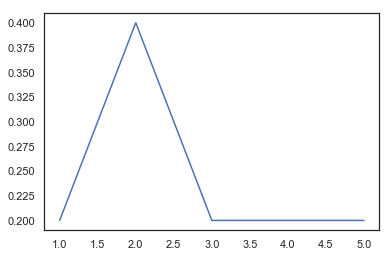

In [8]:
pmf.plot()

And a bar method that displays the `Pmf` as a bar plot.

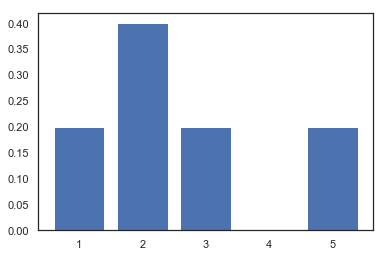

In [9]:
pmf.bar()

`Pmf` makes the quantities available as a property, `qs`.

In [10]:
pmf.qs

array([1, 2, 3, 5])

And the probabilities available as a property, `ps`.  Both return NumPy arrays.

In [11]:
pmf.ps

array([0.2, 0.4, 0.2, 0.2])

The following are unit tests for `Pmf` objects:

In [12]:
def run_tests():
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

class TestPmf(unittest.TestCase):

    def test_pmf(self):
        seq = [5, 3, 2, 2, 1]
        pmf = Pmf(seq)
        self.assertEqual(pmf(1), 0.2)
        self.assertEqual(pmf(2), 0.4)
        self.assertEqual(pmf(4), 0.0)

    def test_pmf_normalize_false(self):
        seq = [5, 3, 2, 2, 1]
        pmf = Pmf(seq, normalize=False)
        self.assertEqual(pmf(1), 1)
        self.assertEqual(pmf(2), 2)
        self.assertEqual(pmf(4), 0)
    
run_tests()

..
----------------------------------------------------------------------
Ran 2 tests in 0.007s

OK


## CDF

The `Cdf` class also inherits from `Series`.

The constructor takes a sequence of values.  First it makes a sorted `Pmf`, then it computes the cumulative sum of the probabilities.  If normalized, it divides the cumulative probabilities by the last cumulative probability, which is the total.

In [13]:
from scipy.interpolate import interp1d

class Cdf(pd.Series):

    def __init__(self, seq, name='Cdf', **options):
        """Make a CDF from a sequence.
        
        seq: sequence of values
        name: string
        sort: boolean, whether to sort the values, default True
        normalize: boolean, whether to normalize the Cdf, default True
        dropna: boolean, whether to drop NaN, default True
        """
        # get the normalize option
        normalize = options.pop('normalize', True)
        
        # make the PMF and CDF
        pmf = Pmf(seq, normalize=False, **options)
        cdf = pmf.cumsum()
        
        # normalizing the CDF, rather than the PMF,
        # avoids floating-point errors and guarantees
        # that the last proability is 1.0
        if normalize:
            cdf /= cdf.values[-1]
        super().__init__(cdf, name=name, copy=False)
        
    @property
    def qs(self):
        return self.index.values

    @property
    def ps(self):
        return self.values

    @property
    def forward(self):
        return interp1d(self.qs, self.ps,
                        kind='previous',
                        assume_sorted=True,
                        bounds_error=False,
                        fill_value=(0,1))

    @property
    def inverse(self):
        return interp1d(self.ps, self.qs,
                        kind='next',
                        assume_sorted=True,
                        bounds_error=False,
                        fill_value=(self.qs[0], np.nan))

    def __call__(self, qs):
        return self.forward(qs)

    def percentile_rank(self, qs):
        return self.forward(qs) * 100

    def percentile(self, percentile_ranks):
        return self.inverse(percentile_ranks / 100)

    def step(self, **options):
        """Plot the CDF as a step function."""
        underride(options, label=self.name, where='post')
        plt.step(self.index, self.values, **options)

    def plot(self, **options):
        """Plot the CDF as a line."""
        underride(options, label=self.name)
        plt.plot(self.index, self.values, **options)

Here's an example.

In [14]:
cdf = Cdf([5, 3, 2, 2, 1])

1    0.2
2    0.6
3    0.8
5    1.0
Name: Cdf, dtype: float64

The quantities are available as a property, `qs`:

In [15]:
cdf.qs

array([1, 2, 3, 5])

The cumulative probabilities are available as a property, `ps`:

In [16]:
cdf.ps

array([0.2, 0.6, 0.8, 1. ])

Cdf provides a method, `step`, that plots the CDF as a step function (which is technically what it is).

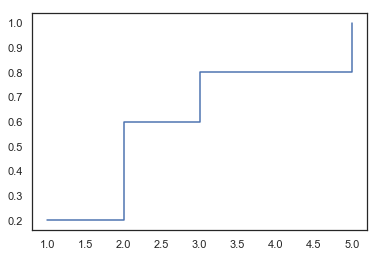

In [17]:
cdf.step()

It also provides `plot`, which plots the CDF as a line plot.

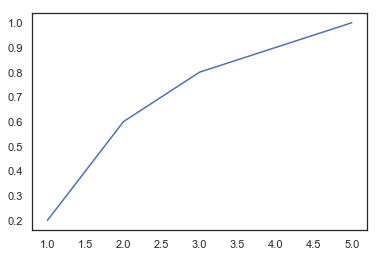

In [18]:
cdf.plot()

Here's an example that uses forward lookup to get the cumulative probabilities for a sequence of quantities.

In [19]:
qs = [0, 1, 1.5, 2, 2.5, 3, 4, 5, 6]
cdf(qs)

array([0. , 0.2, 0.2, 0.6, 0.6, 0.8, 0.8, 1. , 1. ])

The function call syntax is equivalent to calling the `forward` method.

In [20]:
qs = [0, 1, 1.5, 2, 2.5, 3, 4, 5, 6]
cdf.forward(qs)

array([0. , 0.2, 0.2, 0.6, 0.6, 0.8, 0.8, 1. , 1. ])

Here's an example that uses `inverse` to compute the quantities for range of probabilities.

In [21]:
ps = np.linspace(0, 1, 6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [22]:
cdf.inverse(ps)

array([1., 1., 2., 3., 3., 5.])

And here are some unit tests for `Cdf`.

In [23]:
class TestCdf(unittest.TestCase):

    def test_cdf(self):
        seq = [5, 3, 2, 2, 1]
        cdf = Cdf(seq)
        self.assertAlmostEqual(cdf(0), 0)
        self.assertAlmostEqual(cdf(1), 0.2)
        self.assertAlmostEqual(cdf(2), 0.6)
        self.assertAlmostEqual(cdf(3), 0.8)
        self.assertAlmostEqual(cdf(4), 0.8)
        self.assertAlmostEqual(cdf(5), 1)
        self.assertAlmostEqual(cdf(6), 1)
        
    def test_cdf_inverse(self):
        seq = [5, 3, 2, 2, 1]
        cdf = Cdf(seq)
        self.assertAlmostEqual(cdf.inverse(0), 1)
        self.assertAlmostEqual(cdf.inverse(0.2), 1)
        self.assertAlmostEqual(cdf.inverse(0.3), 2)
        self.assertAlmostEqual(cdf.inverse(0.4), 2)
        self.assertAlmostEqual(cdf.inverse(0.41), 2)
        self.assertAlmostEqual(cdf.inverse(0.6), 2)
        self.assertAlmostEqual(cdf.inverse(0.8), 3)
        self.assertAlmostEqual(cdf.inverse(1), 5)
    
run_tests()

....
----------------------------------------------------------------------
Ran 4 tests in 0.007s

OK
